In [1]:
# devtools::install_github("NPSDC/beaveR", ref = "dev")
library(beaveR)
setwd('/fs/cbcb-lab/rob/students/noor/Uncertainity/treeTerminusScripts')
suppressPackageStartupMessages(source("tree_helper_function.R"))
suppressPackageStartupMessages(library(beaveR))
clustFile <- "../brain_sim_nodtu_lowfc/mode=gc_bias/post_type=gibbs_nrep=100_tf=100/terminus/no_threshold0/cluster_nwk.txt"
quantDir <- file.path("../brain_sim_nodtu_lowfc/mode=gc_bias/post_type=gibbs_nrep=100_tf=100/out_sal") 
samples <- as.vector(outer(c(1:6), c(1,2), function(x,y) paste(x,y,sep='_')))
quantFiles <- file.path(quantDir, samples, 'quant.sf')
coldata <- data.frame(files=quantFiles, names=samples, condition=factor(rep(1:2, each=6)))
# tseCons <- buildTSE(treeTermFile = clustFile, coldata = coldata)

In [2]:
saveDir <- "environment/brain_sim_nodtu_lowfc/mode=gc_bias/post_type=gibbs_nrep=100_tf=100/comp_trees/DE"
load(file.path(saveDir, "cutsCons.RData"))
load(file.path(saveDir, "tseConsUp.RData"))
# save(tse, file=file.path(saveDir, "tseCons.RData"))

In [3]:
library(beaveR)

In [19]:
names(cuts)
nn <- c("lfcTD", 'irv_height_0.05', 'irv_height_0.1', 'irv_height_0.5', 'irv_height_1','irv_height_5','irv_height_10')

[1] "irv_height_0.05"        "irv_height_0.1"         "irv_height_1"          
 [4] "irv_height_5"           "irv_height_10"          "LFC"                   
 [7] "lfcTPMDesc"             "irv_height=0.1_LFC=0.1" "irv_height=0.1_LFC=1"  
[10] "irv_height=0.1_LFC=5"   "irv_height=0.5_LFC=0.1" "irv_height=0.5_LFC=1"  
[13] "irv_height=0.5_LFC=5"   "irv_height=1_LFC=0.1"   "irv_height=1_LFC=1"    
[16] "irv_height=1_LFC=5"     "irv_height=5_LFC=0.1"   "irv_height=5_LFC=1"    
[19] "irv_height=5_LFC=5"     "lfcTPM"                 "irv_height_0.5"        
[22] "lfcTD"                  "lfcT"                   "LFCD"

In [8]:
load("environment/brain_sim_nodtu_lowfc/simulate.rda")
suppressPackageStartupMessages(library(TreeSummarizedExperiment))
suppressPackageStartupMessages(library(ape))
tree <- rowTree(tseCons)
l <- length(tree$tip)
missingTxps <- setdiff(rownames(tseCons)[1:l], rownames(sim.counts.mat))
dts <- Reduce(union, c(names(iso.dge)[iso.dge], names(iso.dte)[iso.dte], names(iso.dte.only)[iso.dte.only], 
                       names(iso.dtu)[iso.dtu]))
dts <- intersect(dts, rownames(sim.counts.mat))
sim.counts.mat <- rbind(sim.counts.mat, matrix(0, nrow = length(missingTxps), ncol = ncol(sim.counts.mat),
                                               dimnames = list(missingTxps, colnames(sim.counts.mat))))
sim.counts.mat <- sim.counts.mat[rownames(tseCons)[1:l],]
dts <- intersect(dts, rownames(sim.counts.mat))

innNodes <- l+1:tree$Nnode
aggCountsNodes <- computeAggNodesU(tree, c(1:length(tree$tip),innNodes), sim.counts.mat)
logFCNodes <- ifelse(rowSums(aggCountsNodes)==0, 0, log2(aggCountsNodes[,2]+1)-log2(aggCountsNodes[,1]+1))
names(logFCNodes)[(l+1):length(logFCNodes)] <- paste("Node", names(logFCNodes)[(l+1):length(logFCNodes)], sep="")
rootFC <- abs(logFCNodes[l+1])


In [9]:
temp <- tseCons
length(dts)
summary(abs(logFCNodes[dts]))
print(mean(abs(logFCNodes[dts]) >= rootFC))
rootFC
mcols(tseCons)[["meanInfRV"]][l+1]

[1] 8777

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.4257  0.7804  1.0273  1.0096  1.2607  1.4836 

[1] 1


Node138290 
0.01270299

Node138290 
      0.01

#### Run Swish

In [11]:
set.seed(1)
y <- fishpond::scaleInfReps(temp[1:l,])
y <- labelKeep(y)
y <- swish(y, x="condition")

In [13]:
detNodes <- list()
detNodes[["Txps"]] <- lapply(c(0.01, 0.05, 0.1), function(x) which(mcols(y)[,"qvalue"] <= x ))

negNodes <- list()
negNodes[["Txps"]] <- lapply(detNodes[["Txps"]], function(nodes) setdiff(seq(l), 
                                                          unlist(Descendants(tree, nodes))))

#### Run Genes

In [12]:
gse <- summarizeToGene(tse[1:l,])
dg <- union(dge.genes, dte.genes)
length(dg)
sum(dg %in% rownames(gse))
dg <- intersect(dge.genes, rownames(gse))

gse <- fishpond::scaleInfReps(gse)
gse <- labelKeep(gse)
set.seed(1)
gse <- swish(gse, x="condition")
detNodes[["Genes"]] <- lapply(c(0.01, 0.05, 0.1), function(x) which(mcols(gse)[,"qvalue"] <= x ))
negNodes[["Genes"]] <- lapply(detNodes[["Genes"]], function(nodes) setdiff(seq(nrow(gse)), nodes))

loading existing TxDb created: 2023-03-02 17:08:07

Loading required package: GenomicFeatures

Loading required package: AnnotationDbi

obtaining transcript-to-gene mapping from database

loading existing gene ranges created: 2023-03-02 17:08:18

summarizing abundance

summarizing counts

summarizing length

summarizing inferential replicates



[1] 4150

[1] 4096

In [24]:
for(cuName in nn[2:4]) {
    y <- temp[sort(cuts[[cuName]]),]
    y <- fishpond::scaleInfReps(y)
    y <- labelKeep(y)
    set.seed(1)
    y <- swish(y, x="condition")
    detNodes[[cuName]] <- lapply(c(0.01, 0.05, 0.1), function(x) {
        nodes <- rownames(y)[which(mcols(y)[,"qvalue"] <= x)]
         match(nodes, names(logFCNodes))

    })
    negNodes[[cuName]] <- lapply(c(0.01, 0.05, 0.1), function(x) {
        nodes <- rownames(y)[setdiff(seq(nrow(y)), which(mcols(y)[,"qvalue"] <= x))]
        match(nodes, names(logFCNodes))
    })
}

In [16]:
df <- data.frame(Method=character(), Metric=character(), FDR_0.01 = numeric(), FDR_0.05 = numeric(), FDR_0.10 = numeric())
for(n in names(detNodes))
{
    if(!n%in%c("term", "Genes")) {
        print(n)
        stats <-  sapply(seq_along(detNodes[[n]]), function(i) computeMetOut(detNodes[[n]][[i]], logFCNodes, tree = tree, negNodes = negNodes[[n]][[i]], lfcThresh = rootFC))
        colnames(stats) <- colnames(df)[c(3:5)]
        stats <- cbind(Method=rep(n,2), Metric = c("FDR", "TPR"), stats)
        df <- rbind(df, stats)
        
    }
    
}
print(df)

[1] "Txps"
[1] "tp 0.99184339314845"
[1] "tp 0.960952380952381"
[1] "tp 0.919753086419753"
[1] "lfcTD"
[1] "tp 0.993719469644103"
[1] "tp 0.962639495390587"
[1] "tp 0.919394435351882"
[1] "irv_height_1"
[1] "tp 0.992537313432836"
[1] "tp 0.96005655708731"
[1] "tp 0.92432273262662"
[1] "irv_height_5"
[1] "tp 0.992999461497038"
[1] "tp 0.959729381443299"
[1] "tp 0.917125622869132"
[1] "irv_height_10"
[1] "tp 0.999063670411985"
[1] "tp 0.975517890772128"
[1] "tp 0.935115566694514"
            Method Metric     FDR_0.01   FDR_0.05   FDR_0.10
fdr           Txps    FDR  0.008156607 0.03904762 0.08024691
tpr           Txps    TPR    0.2078159  0.3448787  0.4074285
fdr1         lfcTD    FDR   0.00628053  0.0373605 0.08060556
tpr1         lfcTD    TPR    0.3140022  0.4374862  0.4954796
fdr2  irv_height_1    FDR  0.007462687 0.03994344 0.07567727
tpr2  irv_height_1    TPR    0.2348547  0.3689215  0.4263787
fdr3  irv_height_5    FDR  0.007000539 0.04027062 0.08287438
tpr3  irv_height_5    TPR    

In [12]:
suppressPackageStartupMessages(library(tidyr))
dfA <- df %>% pivot_wider(names_from = Metric, values_from = c(3:5))
dfA <- dfA[,c(1,seq(2,7,2),seq(3,7,2))]
colnames(dfA)[c(2:7)] <- as.vector(outer(c(0.01,0.05,0.1), c("FDR","TPR"), function(x,y) paste(x,y,sep="_")))
for(i in seq(ncol(dfA)-1))
    dfA[,i+1] <- round(as.numeric(unlist(dfA[,i+1])),3)
dfA

ERROR: Error in UseMethod("pivot_wider"): no applicable method for 'pivot_wider' applied to an object of class "function"


In [25]:
df <- data.frame(Method=character(), Metric=character(), FDR_0.01 = numeric(), FDR_0.05 = numeric(), FDR_0.10 = numeric())
for(n in names(detNodes))
{
    if(!n%in%c("term", "Genes")) {
        print(n)
        stats <-  sapply(seq_along(detNodes[[n]]), function(i) computeMetOut(detNodes[[n]][[i]], logFCNodes, tree = tree, negNodes = negNodes[[n]][[i]], lfcThresh = rootFC))
        colnames(stats) <- colnames(df)[c(3:5)]
        stats <- cbind(Method=rep(n,2), Metric = c("FDR", "TPR"), stats)
        df <- rbind(df, stats)
        
    }
    
}
suppressPackageStartupMessages(library(tidyr))
dfA <- df %>% pivot_wider(names_from = Metric, values_from = c(3:5))
dfA <- dfA[,c(1,seq(2,7,2),seq(3,7,2))]
colnames(dfA)[c(2:7)] <- as.vector(outer(c(0.01,0.05,0.1), c("FDR","TPR"), function(x,y) paste(x,y,sep="_")))
for(i in seq(ncol(dfA)-1))
    dfA[,i+1] <- round(as.numeric(unlist(dfA[,i+1])),3)
dfA

[1] "lfcTD"
[1] "tp 0.993719469644103"
[1] "tp 0.962639495390587"
[1] "tp 0.919394435351882"
[1] "irv_height_0.05"
[1] "tp 0.994413407821229"
[1] "tp 0.967197298601061"
[1] "tp 0.930166463662201"
[1] "irv_height_0.1"
[1] "tp 0.994708994708995"
[1] "tp 0.96625626994984"
[1] "tp 0.929112964366945"
[1] "irv_height_0.5"
[1] "tp 0.99400479616307"
[1] "tp 0.966108149276466"
[1] "tp 0.925844114862733"


Method          0.01_FDR 0.05_FDR 0.1_FDR 0.01_TPR 0.05_TPR 0.1_TPR
1 lfcTD           0.006    0.037    0.081   0.314    0.437    0.495  
2 irv_height_0.05 0.006    0.033    0.070   0.283    0.398    0.455  
3 irv_height_0.1  0.005    0.034    0.071   0.273    0.385    0.445  
4 irv_height_0.5  0.006    0.034    0.074   0.244    0.373    0.432

#### Parse Terminus

In [16]:
suppressPackageStartupMessages(source("old_terminus_helper.R"))
dir <- "/fs/cbcb-lab/rob/students/noor/Uncertainity/brain_sim_nodtu_lowfc/mode=gc_bias/post_type=gibbs_nrep=100_tf=100/terminus/"
seBrainSim <- tximeta(coldata)
yTermThrNS <- seBrainSim[rownames(tse)[1:l],]
groupsClust <- parseClustFile(file.path(dir, "old", "1_1", "clusters.txt"), yTermThrNS)
mInds <- seq(nrow(yTermThrNS) + length(groupsClust))
yAggTermThrNS <- prepOSwish(yTermThrNS, mInds, groupsClust)

rownames(yAggTermThrNS)[l+1:length(groupsClust)] <- paste("Node", as.character(l+1:length(groupsClust)),sep="")
metadata(yAggTermThrNS)[["txpsAnn"]] <- rowData(yTermThrNS)
yAggTermThrNS <- yAggTermThrNS[-unlist(groupsClust),]
dim(yAggTermThrNS)

importing quantifications

reading in files with read_tsv

1 
2 
3 
4 
5 
6 
7 
8 
9 
10 
11 
12 


found matching transcriptome:
[ GENCODE - Homo sapiens - release 26 ]

loading existing TxDb created: 2022-08-19 22:12:59

Loading required package: GenomicFeatures

Loading required package: AnnotationDbi

loading existing transcript ranges created: 2022-08-19 22:13:01



[1] 130016     12

In [17]:
aggCountsNodes <- computeOAggNodesU(groupsClust, mInds, sim.counts.mat)
logFCNodesTerm <- ifelse(rowSums(aggCountsNodes)==0, 0, log2(aggCountsNodes[,2]+1)-log2(aggCountsNodes[,1]+1))
names(logFCNodesTerm)[(l+1):length(logFCNodesTerm)] <- paste("Node", names(logFCNodesTerm)[(l+1):length(logFCNodesTerm)], sep="")


In [ ]:
yAggTermThrNS <- fishpond::scaleInfReps(yAggTermThrNS)
yAggTermThrNS <- labelKeep(yAggTermThrNS)
set.seed(1)
yAggTermThrNS <- swish(yAggTermThrNS, x="condition")

In [18]:
detNodes[["term"]] <- lapply(c(0.01, 0.05, 0.1), function(x) {
        nodes <- rownames(yAggTermThrNS)[which(mcols(yAggTermThrNS)[,"qvalue"] <= x)]
        match(nodes, names(logFCNodesTerm))
    })
negNodes[["term"]] <- lapply(c(0.01, 0.05, 0.1), function(x) {
        nodes <- rownames(yAggTermThrNS)[setdiff(seq(nrow(yAggTermThrNS)),
                                                 which(mcols(yAggTermThrNS)[,"qvalue"] <= x))]
        match(nodes, names(logFCNodesTerm))
    })
stats <-  sapply(seq_along(detNodes[["term"]]), function(i) computeMetOut(detNodes[["term"]][[i]], 
                                                                          logFCNodesTerm, tree = NULL, 
                                                                          negNodes = negNodes[["term"]][[i]],
                                                                          lfcThresh = rootFC))
colnames(stats) <- colnames(df)[c(3:5)]
stats <- cbind(Method=rep("term",2), Metric = c("FDR", "TPR"), stats)
df <- rbind(df, stats)


[1] "tp 0.992320351069665"
[1] "tp 0.96164199192463"
[1] "tp 0.92051352089593"


In [24]:
dg <- union(dge.genes, dte.genes)
length(dg)
sum(dg %in% rownames(gse))
dg <- intersect(dg, rownames(gse))
length(dg)
tG <- match(dg, rownames(gse))
length(tG)
stats <- sapply(detNodes[["Genes"]], function(genes) {
    computeTPFP(tG, genes, seq(nrow(gse)), seq(nrow(gse)))
})
colnames(stats) <- colnames(df)[c(3:5)]
stats <- cbind(Method=rep("Gene",2), Metric = c("FDR", "TPR"), stats)
stats
df <- rbind(df, stats)

[1] 4150

[1] 4096

[1] 4096

[1] 4096

Method Metric FDR_0.01   FDR_0.05   FDR_0.10  
fdr Gene   FDR    0.00190295 0.02537486 0.06066262
tpr Gene   TPR    0.2561035  0.4125977  0.4914551

In [25]:
suppressPackageStartupMessages(library(tidyr))
dfA <- df %>% pivot_wider(names_from = Metric, values_from = c(3:5))
dfA <- dfA[,c(1,seq(2,7,2),seq(3,7,2))]
colnames(dfA)[c(2:7)] <- as.vector(outer(c(0.01,0.05,0.1), c("FDR","TPR"), function(x,y) paste(x,y,sep="_")))
for(i in seq(ncol(dfA)-1))
    dfA[,i+1] <- round(as.numeric(unlist(dfA[,i+1])),3)


Method                 0.01_FDR 0.05_FDR 0.1_FDR 0.01_TPR 0.05_TPR 0.1_TPR
1  Txps                   0.008    0.039    0.079   0.208    0.345    0.407  
2  irv_height=0.1_LFC=0.1 0.005    0.032    0.069   0.272    0.384    0.446  
3  irv_height=0.1_LFC=1   0.001    0.028    0.064   0.200    0.375    0.440  
4  irv_height=0.1_LFC=5   0.005    0.032    0.070   0.272    0.390    0.446  
5  irv_height=0.5_LFC=0.1 0.007    0.035    0.074   0.246    0.375    0.433  
6  irv_height=0.5_LFC=1   0.005    0.034    0.074   0.241    0.371    0.430  
7  irv_height=0.5_LFC=5   0.007    0.035    0.078   0.248    0.372    0.429  
8  irv_height=1_LFC=0.1   0.007    0.040    0.075   0.239    0.367    0.425  
9  irv_height=1_LFC=1     0.008    0.041    0.082   0.244    0.374    0.432  
10 irv_height=1_LFC=5     0.001    0.027    0.065   0.155    0.342    0.411  
11 irv_height=5_LFC=0.1   0.007    0.033    0.072   0.214    0.342    0.403  
12 irv_height=5_LFC=1     0.007    0.039    0.080   0.216    0.351    0.412  
13 irv_height=5_LFC=5     0.007    0.036    0.073   0.217    0.342    0.403  
14 lfcTPMDesc             0.008    0.044    0.087   0.336    0.460    0.519  
15 lfcTPM                 0.007    0.037    0.083   0.281    0.402    0.462  
16 LFC                    0.007    0.036    0.081   0.278    0.400    0.462  
17 irv_height_0.1         0.005    0.034    0.070   0.273    0.385    0.445  
18 irv_height_0.05        0.006    0.033    0.070   0.283    0.398    0.455  
19 irv_height_1           0.007    0.040    0.075   0.235    0.368    0.426  
20 irv_height_5           0.007    0.040    0.083   0.220    0.356    0.418  
21 irv_height_10          0.001    0.024    0.065   0.124    0.301    0.390  
22 term                   0.008    0.038    0.079   0.223    0.352    0.415  
23 irv_height_0.5         0.006    0.034    0.074   0.244    0.373    0.432  
24 Gene                   0.002    0.025    0.061   0.256    0.413    0.491

In [31]:
dfA <- dfA[order(unlist(dfA$Method)),]
r <- nrow(dfA)
dfA[c(1, r, r-1, 2:(r-2)),]

Method                 0.01_FDR 0.05_FDR 0.1_FDR 0.01_TPR 0.05_TPR 0.1_TPR
1  Gene                   0.002    0.025    0.061   0.256    0.413    0.491  
2  Txps                   0.008    0.039    0.079   0.208    0.345    0.407  
3  term                   0.008    0.038    0.079   0.223    0.352    0.415  
4  irv_height_0.05        0.006    0.033    0.070   0.283    0.398    0.455  
5  irv_height_0.1         0.005    0.034    0.070   0.273    0.385    0.445  
6  irv_height_0.5         0.006    0.034    0.074   0.244    0.373    0.432  
7  irv_height_1           0.007    0.040    0.075   0.235    0.368    0.426  
8  irv_height_10          0.001    0.024    0.065   0.124    0.301    0.390  
9  irv_height_5           0.007    0.040    0.083   0.220    0.356    0.418  
10 irv_height=0.1_LFC=0.1 0.005    0.032    0.069   0.272    0.384    0.446  
11 irv_height=0.1_LFC=1   0.001    0.028    0.064   0.200    0.375    0.440  
12 irv_height=0.1_LFC=5   0.005    0.032    0.070   0.272    0.390    0.446  
13 irv_height=0.5_LFC=0.1 0.007    0.035    0.074   0.246    0.375    0.433  
14 irv_height=0.5_LFC=1   0.005    0.034    0.074   0.241    0.371    0.430  
15 irv_height=0.5_LFC=5   0.007    0.035    0.078   0.248    0.372    0.429  
16 irv_height=1_LFC=0.1   0.007    0.040    0.075   0.239    0.367    0.425  
17 irv_height=1_LFC=1     0.008    0.041    0.082   0.244    0.374    0.432  
18 irv_height=1_LFC=5     0.001    0.027    0.065   0.155    0.342    0.411  
19 irv_height=5_LFC=0.1   0.007    0.033    0.072   0.214    0.342    0.403  
20 irv_height=5_LFC=1     0.007    0.039    0.080   0.216    0.351    0.412  
21 irv_height=5_LFC=5     0.007    0.036    0.073   0.217    0.342    0.403  
22 LFC                    0.007    0.036    0.081   0.278    0.400    0.462  
23 lfcTPM                 0.007    0.037    0.083   0.281    0.402    0.462  
24 lfcTPMDesc             0.008    0.044    0.087   0.336    0.460    0.519

In [32]:
saveDir <- "environment/brain_sim_nodtu_lowfc/mode=gc_bias/post_type=gibbs_nrep=100_tf=100/comp_trees/DE"
save(negNodes, file = file.path(saveDir, "negNodesCons.RData"))
save(detNodes, file = file.path(saveDir, "detNodesCons.RData"))
save(cuts, file=file.path(saveDir, "cutsCons.RData"))
save(df, file=file.path(saveDir, "dfCons.RData"))

In [103]:
suppressPackageStartupMessages(library(tidyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(ggpubr))
load(file=file.path(saveDir, "dfCons.RData"))
dfB <- cbind(gather(df[seq(1, nrow(df), 2),], key = "NFDR", value = "FDR", 3:5),
gather(df[seq(2, nrow(df), 2),], key = "NFDR", value = "TPR", 3:5))
dfB <- dfB[, c(1,3,4,8)]
dfB[["meetCriteria"]] <- rep(FALSE, nrow(dfB))
l <- length(unique(df$Method))
for(i in seq(3)) {
    start <- (i-1)*l+1
    end <- start+l-1
    dfB$meetCriteria[start:end] <- dfB$FDR[start:end] <= c(0.01,0.05,0.1)[i]
}

dfB <- data.frame(do.call(cbind, lapply(dfB, unlist)))
dfB[,c(3)] <- as.numeric(dfB[,c(3)])
dfB[,c(4)] <- as.numeric(dfB[,c(4)])
dfB

ERROR: Error in data.frame(..., check.names = FALSE): arguments imply differing number of rows: 18, 15


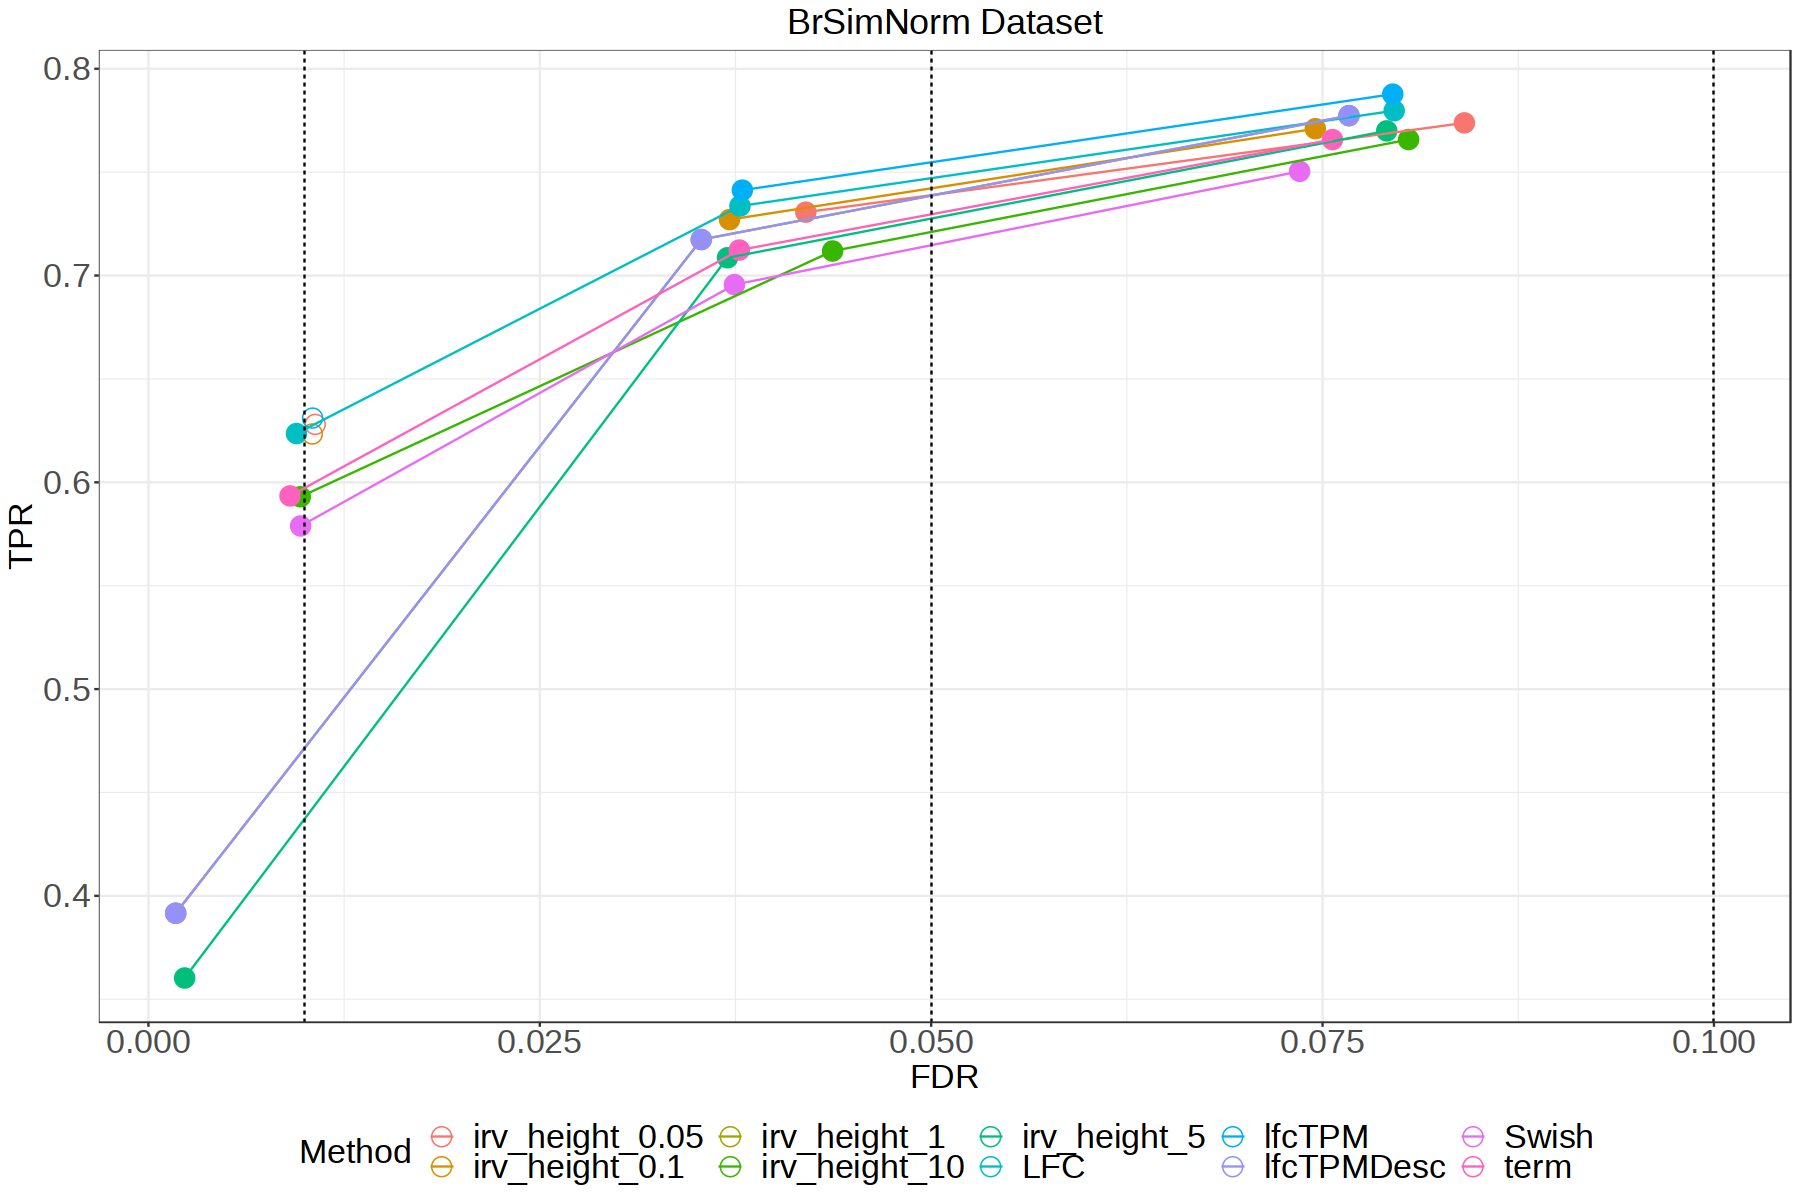

In [6]:
options(repr.plot.width=15, repr.plot.height=10)
size <- 20
pCons <- ggplot(dfB, aes(x = FDR, y = TPR, 
                             color = Method,
                             fill = ifelse(meetCriteria, Method, NA))) + 
                geom_point(size=5,shape=21) + 
                scale_fill_discrete(na.value = "transparent") +
                geom_line() +
                theme_bw() +
                geom_vline(xintercept = c(0.01, 0.05, 0.1), linetype = "dashed") +
                ggtitle("BrSimNorm Dataset") +
                theme(axis.title = element_text(size = size),
                plot.title = element_text(size = size + 1, hjust=0.5),
                axis.text = element_text(size = size),
                legend.text = element_text(size = size),
                legend.title = element_text(size = size),
                legend.position = "bottom") +
                guides(fill = "none")
pCons

In [33]:
negNodesDesc <- list()
for(n in names(negNodes)) {
    if(n == "Swish")
        negNodesDesc[[n]] <- negNodes[[n]]
    if(n != "term")
        negNodesDesc[[n]] <- lapply(negNodes[[n]], function(x) unlist(Descendants(tree, x)))
}
negNodesDesc[["term"]] <- lapply(negNodes[["term"]], function(x) {
    dd <- x[x>l]
    r <- setdiff(x, dd)
    dd <- dd - l
    c(unlist(groupsClust[dd]), r) 
})

In [34]:
dfO <- data.frame(Method=character(), Metric=character(), FDR_0.01 = numeric(), FDR_0.05 = numeric(), FDR_0.10 = numeric())
for(n in names(detNodes))
{
    print(n)
    if(!n %in% c("term", "Genes")) {
        stats <-  sapply(seq_along(detNodes[[n]]), function(i) computeMetOut(detNodes[[n]][[i]], 
                                                                             logFCNodes, tree = tree, 
                                                                             negNodes = negNodesDesc[[n]][[i]], 
                                                                             lfcThresh = rootFC))
        colnames(stats) <- colnames(df)[c(3:5)]
        stats <- cbind(Method=rep(n,2), Metric = c("FDR", "TPR"), stats)
        dfO <- rbind(dfO, stats)
    }
    
}
stats <-  sapply(seq_along(detNodes[["term"]]), function(i) computeMetOut(detNodes[["term"]][[i]], 
                                              logFCNodesTerm, tree = NULL, 
                                              negNodes = negNodesDesc[["term"]][[i]],
                                              lfcThresh = rootFC))
colnames(stats) <- colnames(df)[c(3:5)]
stats <- cbind(Method=rep("term",2), Metric = c("FDR", "TPR"), stats)
dfO <- rbind(dfO, stats)

tG <- match(dg, rownames(gse))
stats <- sapply(detNodes[["Genes"]], function(genes) {
    computeTPFP(tG, genes, seq(nrow(gse)), seq(nrow(gse)))
})
colnames(stats) <- colnames(df)[c(3:5)]
stats <- cbind(Method=rep("Genes",2), Metric = c("FDR", "TPR"), stats)
dfO <- rbind(dfO, stats)

print(dfO)

[1] "Txps"
[1] "tp 0.99185667752443"
[1] "tp 0.960964773087909"
[1] "tp 0.920679886685552"
[1] "Genes"
[1] "irv_height=0.1_LFC=0.1"
[1] "tp 0.99468085106383"
[1] "tp 0.967992684042067"
[1] "tp 0.931034482758621"
[1] "irv_height=0.1_LFC=1"
[1] "tp 0.99908592321755"
[1] "tp 0.972485768500949"
[1] "tp 0.936477007014809"
[1] "irv_height=0.1_LFC=5"
[1] "tp 0.994550408719346"
[1] "tp 0.967622571692877"
[1] "tp 0.929654100272056"
[1] "irv_height=0.5_LFC=0.1"
[1] "tp 0.993456276026175"
[1] "tp 0.965491088357983"
[1] "tp 0.925645872715816"
[1] "irv_height=0.5_LFC=1"
[1] "tp 0.994528875379939"
[1] "tp 0.966244725738397"
[1] "tp 0.926195755464048"
[1] "irv_height=0.5_LFC=5"
[1] "tp 0.993361496680748"
[1] "tp 0.964857477547833"
[1] "tp 0.921511627906977"
[1] "irv_height=1_LFC=0.1"
[1] "tp 0.992651215375919"
[1] "tp 0.960213143872114"
[1] "tp 0.924940898345154"
[1] "irv_height=1_LFC=1"
[1] "tp 0.992235163616195"
[1] "tp 0.959440559440559"
[1] "tp 0.918260869565217"
[1] "irv_height=1_LFC=5"
[1] "tp 

In [90]:
dfO

Method          Metric FDR_0.01     FDR_0.05   FDR_0.10  
fdr   Txps            FDR    0.008143322  0.03903523 0.07932011
tpr   Txps            TPR    0.2081577    0.3449926  0.4073146 
fdr1  irv_height_0.05 FDR    0.005582694  0.0328027  0.0698619 
tpr1  irv_height_0.05 TPR    0.2303589    0.3432044  0.3997905 
fdr2  irv_height_0.1  FDR    0.005291005  0.03374373 0.07020873
tpr2  irv_height_0.1  TPR    0.2315984    0.3404016  0.4009164 
fdr3  irv_height_1    FDR    0.007462687  0.03970223 0.07515473
tpr3  irv_height_1    TPR    0.2208738    0.3531022  0.4114331 
fdr4  irv_height_5    FDR    0.007000539  0.03993559 0.08263379
tpr4  irv_height_5    TPR    0.21712      0.3530736  0.4146804 
fdr5  irv_height_10   FDR    0.0009354537 0.02413273 0.06545961
tpr5  irv_height_10   TPR    0.1228857    0.2992253  0.388535  
fdr6  LFC             FDR    0.007477906  0.03579624 0.08137774
tpr6  LFC             TPR    0.2344628    0.3579216  0.4217935 
fdr7  lfcTPMDesc      FDR    0.007982583  0.04394481 0.08697534
tpr7  lfcTPMDesc      TPR    0.245996     0.371525   0.4337102 
fdr8  lfcTPM          FDR    0.00672043   0.03742583 0.08282905
tpr8  lfcTPM          TPR    0.2378883    0.3593457  0.4212995 
fdr9  term            FDR    0.007679649  0.03835801 0.07948648
tpr9  term            TPR    0.2178993    0.3471817  0.4103751 
fdr10 Genes           FDR    0.00190295   0.02537486 0.06066262
tpr10 Genes           TPR    0.2561035    0.4125977  0.4914551

In [99]:
save(dfO, file=file.path(saveDir, "dfConsO.RData"))

In [35]:
dfB <- dfO %>% pivot_wider(names_from = Metric, values_from = c(3:5))
dfB <- dfB[,c(1,seq(2,7,2),seq(3,7,2))]
colnames(dfB)[c(2:7)] <- as.vector(outer(c(0.01,0.05,0.1), c("FDR","TPR"), function(x,y) paste(x,y,sep="_")))
for(i in seq(ncol(dfB)-1))
    dfB[,i+1] <- round(as.numeric(unlist(dfB[,i+1])),3)
dfB<- dfB[order(unlist(dfB$Method)),]
r <- nrow(dfB)
dfB[c(1, r, r-1, 2:(r-2)),]

Method                 0.01_FDR 0.05_FDR 0.1_FDR 0.01_TPR 0.05_TPR 0.1_TPR
1  Genes                  0.002    0.025    0.061   0.256    0.413    0.491  
2  Txps                   0.008    0.039    0.079   0.208    0.345    0.407  
3  term                   0.008    0.038    0.079   0.218    0.347    0.410  
4  irv_height_0.05        0.006    0.033    0.070   0.230    0.343    0.400  
5  irv_height_0.1         0.005    0.034    0.070   0.232    0.340    0.401  
6  irv_height_0.5         0.006    0.034    0.074   0.222    0.351    0.410  
7  irv_height_1           0.007    0.040    0.075   0.221    0.353    0.411  
8  irv_height_10          0.001    0.024    0.065   0.123    0.299    0.389  
9  irv_height_5           0.007    0.040    0.083   0.217    0.353    0.415  
10 irv_height=0.1_LFC=0.1 0.005    0.032    0.069   0.230    0.340    0.403  
11 irv_height=0.1_LFC=1   0.001    0.028    0.064   0.162    0.329    0.394  
12 irv_height=0.1_LFC=5   0.005    0.032    0.070   0.227    0.343    0.399  
13 irv_height=0.5_LFC=0.1 0.007    0.035    0.074   0.224    0.352    0.410  
14 irv_height=0.5_LFC=1   0.005    0.034    0.074   0.219    0.349    0.408  
15 irv_height=0.5_LFC=5   0.007    0.035    0.078   0.225    0.347    0.405  
16 irv_height=1_LFC=0.1   0.007    0.040    0.075   0.225    0.353    0.411  
17 irv_height=1_LFC=1     0.008    0.041    0.082   0.229    0.359    0.417  
18 irv_height=1_LFC=5     0.001    0.027    0.065   0.142    0.325    0.395  
19 irv_height=5_LFC=0.1   0.007    0.033    0.072   0.211    0.339    0.400  
20 irv_height=5_LFC=1     0.007    0.039    0.080   0.213    0.348    0.409  
21 irv_height=5_LFC=5     0.007    0.036    0.073   0.213    0.339    0.400  
22 LFC                    0.007    0.036    0.081   0.234    0.358    0.422  
23 lfcTPM                 0.007    0.037    0.083   0.238    0.359    0.421  
24 lfcTPMDesc             0.008    0.044    0.087   0.246    0.372    0.434

In [92]:
dfA

Method          0.01_FDR 0.05_FDR 0.1_FDR 0.01_TPR 0.05_TPR 0.1_TPR
1  Txps            0.008    0.039    0.079   0.208    0.345    0.407  
2  irv_height_0.05 0.006    0.033    0.070   0.283    0.398    0.455  
3  irv_height_0.1  0.005    0.034    0.070   0.273    0.385    0.445  
4  irv_height_1    0.007    0.040    0.075   0.235    0.368    0.426  
5  irv_height_5    0.007    0.040    0.083   0.220    0.356    0.418  
6  irv_height_10   0.001    0.024    0.065   0.124    0.301    0.390  
7  LFC             0.007    0.036    0.081   0.278    0.400    0.462  
8  lfcTPMDesc      0.008    0.044    0.087   0.336    0.460    0.519  
9  lfcTPM          0.007    0.037    0.083   0.281    0.402    0.462  
10 term            0.008    0.038    0.079   0.223    0.352    0.415  
11 Gene            0.002    0.025    0.061   0.256    0.413    0.491

In [7]:
load(file=file.path(saveDir, "dfConsO.RData"))
dfB <- cbind(gather(dfO[seq(1, nrow(dfO), 2),], key = "NFDR", value = "FDR", 3:5),
gather(dfO[seq(2, nrow(dfO), 2),], key = "NFDR", value = "TPR", 3:5))
dfB <- dfB[, c(1,3,4,8)]
dfB[["meetCriteria"]] <- rep(FALSE, nrow(dfB))
l <- length(unique(df$Method))
for(i in seq(3)) {
    start <- (i-1)*l+1
    end <- start+l-1
    dfB$meetCriteria[start:end] <- dfB$FDR[start:end] <= c(0.01,0.05,0.1)[i]
}

dfB <- data.frame(do.call(cbind, lapply(dfB, unlist)))
dfB[,c(3)] <- as.numeric(dfB[,c(3)])
dfB[,c(4)] <- as.numeric(dfB[,c(4)])
dfB

Method          NFDR     FDR         TPR       meetCriteria
X1    Swish           FDR_0.01 0.009721952 0.5788816 TRUE        
X1.1  irv_height_0.05 FDR_0.01 0.010654967 0.5848462 FALSE       
X1.2  irv_height_0.1  FDR_0.01 0.010468159 0.5889581 FALSE       
X1.3  irv_height_1    FDR_0.01 0.001743375 0.3795572 TRUE        
X1.4  irv_height_5    FDR_0.01 0.002314050 0.3571598 TRUE        
X1.5  irv_height_10   FDR_0.01 0.009701203 0.5921801 TRUE        
X1.6  LFC             FDR_0.01 0.009456986 0.5933845 TRUE        
X1.7  lfcTPMDesc      FDR_0.01 0.001743375 0.3795572 TRUE        
X1.8  lfcTPM          FDR_0.01 0.010485321 0.6028472 FALSE       
X1.9  term            FDR_0.01 0.009044193 0.5902302 TRUE        
X1.10 Swish           FDR_0.05 0.037433155 0.6956126 TRUE        
X1.11 irv_height_0.05 FDR_0.05 0.041992697 0.6959075 TRUE        
X1.12 irv_height_0.1  FDR_0.05 0.037117904 0.6995065 TRUE        
X1.13 irv_height_1    FDR_0.05 0.035313592 0.7098389 TRUE        
X1.14 irv_height_5    FDR_0.05 0.036988968 0.7071718 TRUE        
X1.15 irv_height_10   FDR_0.05 0.043702201 0.7112014 TRUE        
X1.16 LFC             FDR_0.05 0.037783375 0.7128196 TRUE        
X1.17 lfcTPMDesc      FDR_0.05 0.035313592 0.7098389 TRUE        
X1.18 lfcTPM          FDR_0.05 0.037937020 0.7217262 TRUE        
X1.19 term            FDR_0.05 0.037745261 0.7101485 TRUE        
X1.20 Swish           FDR_0.10 0.073533539 0.7503978 TRUE        
X1.21 irv_height_0.05 FDR_0.10 0.084059336 0.7426499 TRUE        
X1.22 irv_height_0.1  FDR_0.10 0.074538259 0.7456156 TRUE        
X1.23 irv_height_1    FDR_0.10 0.076685621 0.7718321 TRUE        
X1.24 irv_height_5    FDR_0.10 0.079097658 0.7687723 TRUE        
X1.25 irv_height_10   FDR_0.10 0.080496652 0.7651498 TRUE        
X1.26 LFC             FDR_0.10 0.079573793 0.7631579 TRUE        
X1.27 lfcTPMDesc      FDR_0.10 0.076685621 0.7718321 TRUE        
X1.28 lfcTPM          FDR_0.10 0.079482027 0.7718083 TRUE        
X1.29 term            FDR_0.10 0.075631501 0.7639691 TRUE

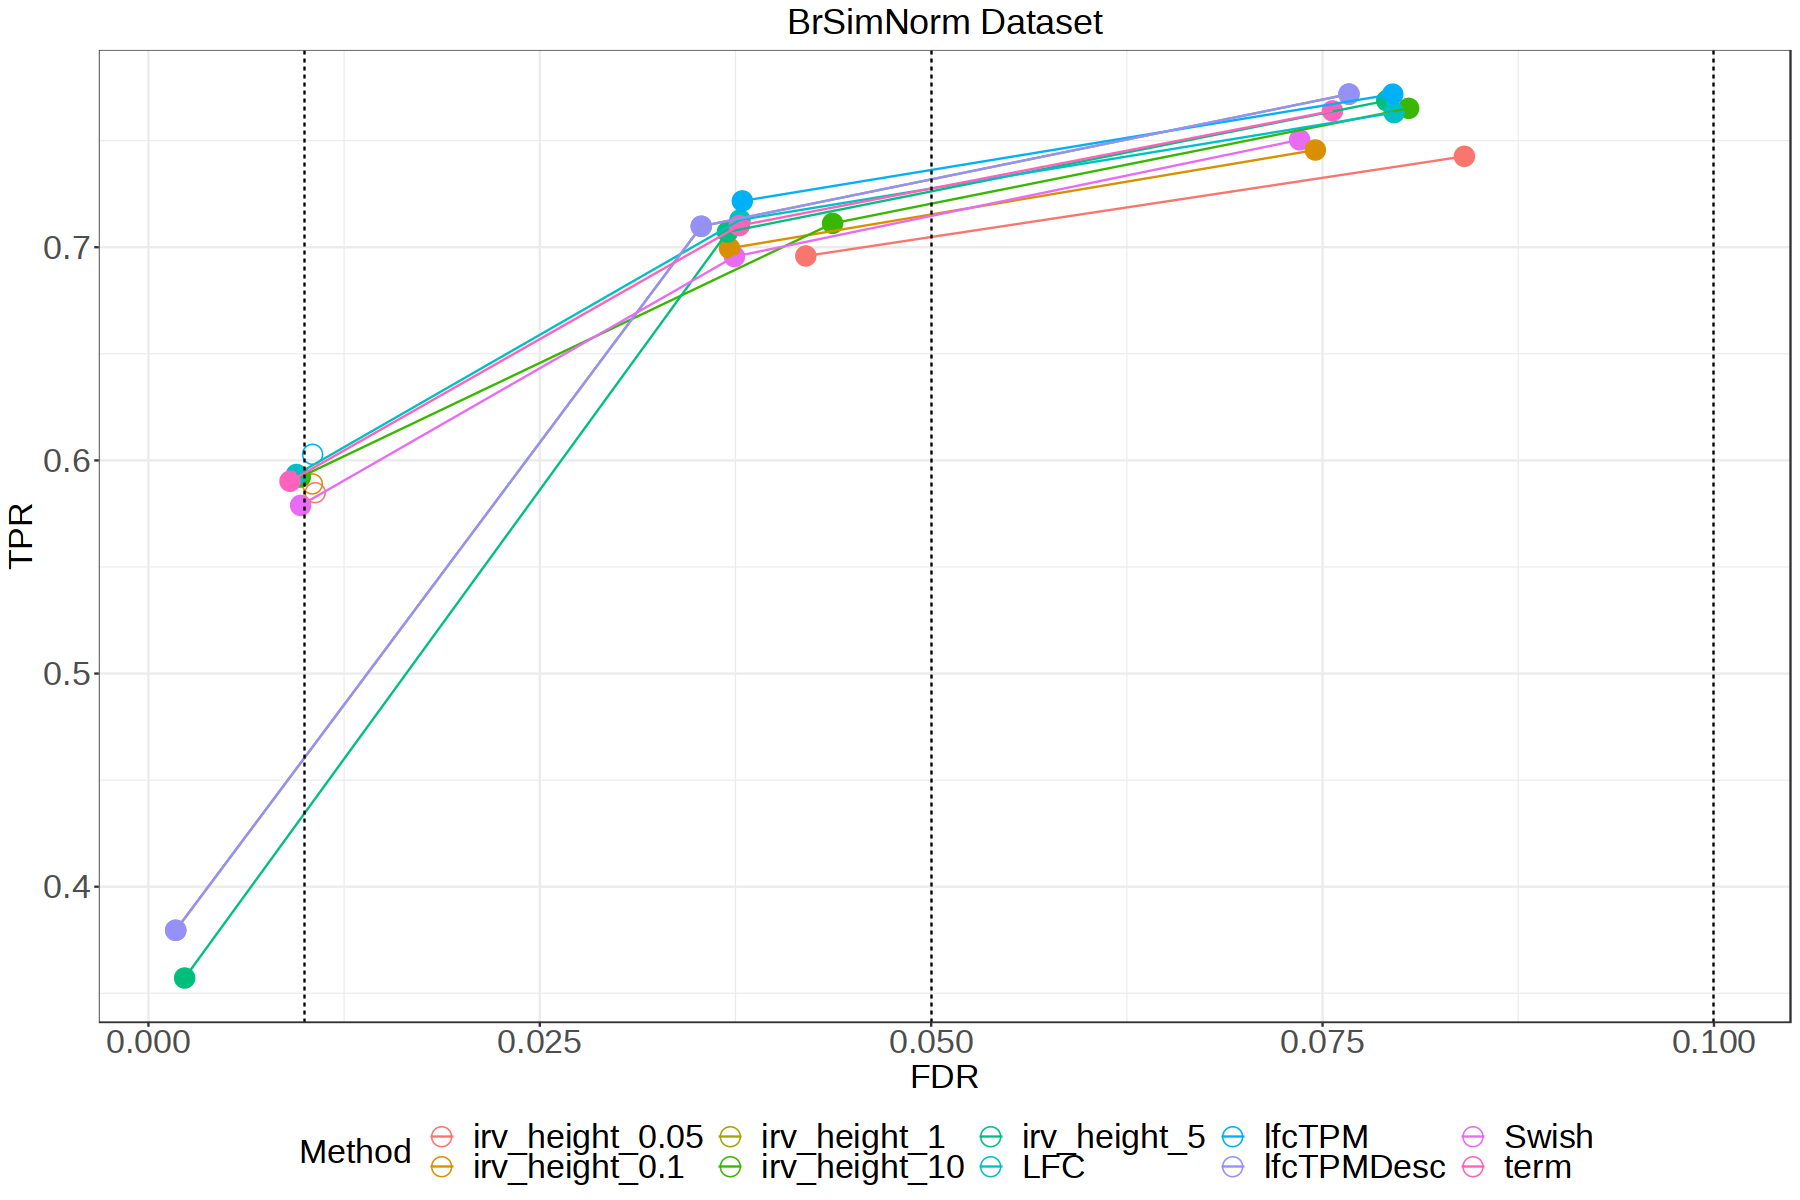

In [8]:
options(repr.plot.width=15, repr.plot.height=10)
size <- 20
pConsDesc <- ggplot(dfB, aes(x = FDR, y = TPR, 
                             color = Method,
                             fill = ifelse(meetCriteria, Method, NA))) + 
                geom_point(size=5,shape=21) + 
                scale_fill_discrete(na.value = "transparent") +
                geom_line() +
                theme_bw() +
                geom_vline(xintercept = c(0.01, 0.05, 0.1), linetype = "dashed") +
                ggtitle("BrSimNorm Dataset") +
                theme(axis.title = element_text(size = size),
                plot.title = element_text(size = size + 1, hjust=0.5),
                axis.text = element_text(size = size),
                legend.text = element_text(size = size),
                legend.title = element_text(size = size),
                legend.position = "bottom") +
                guides(fill = "none")
pConsDesc

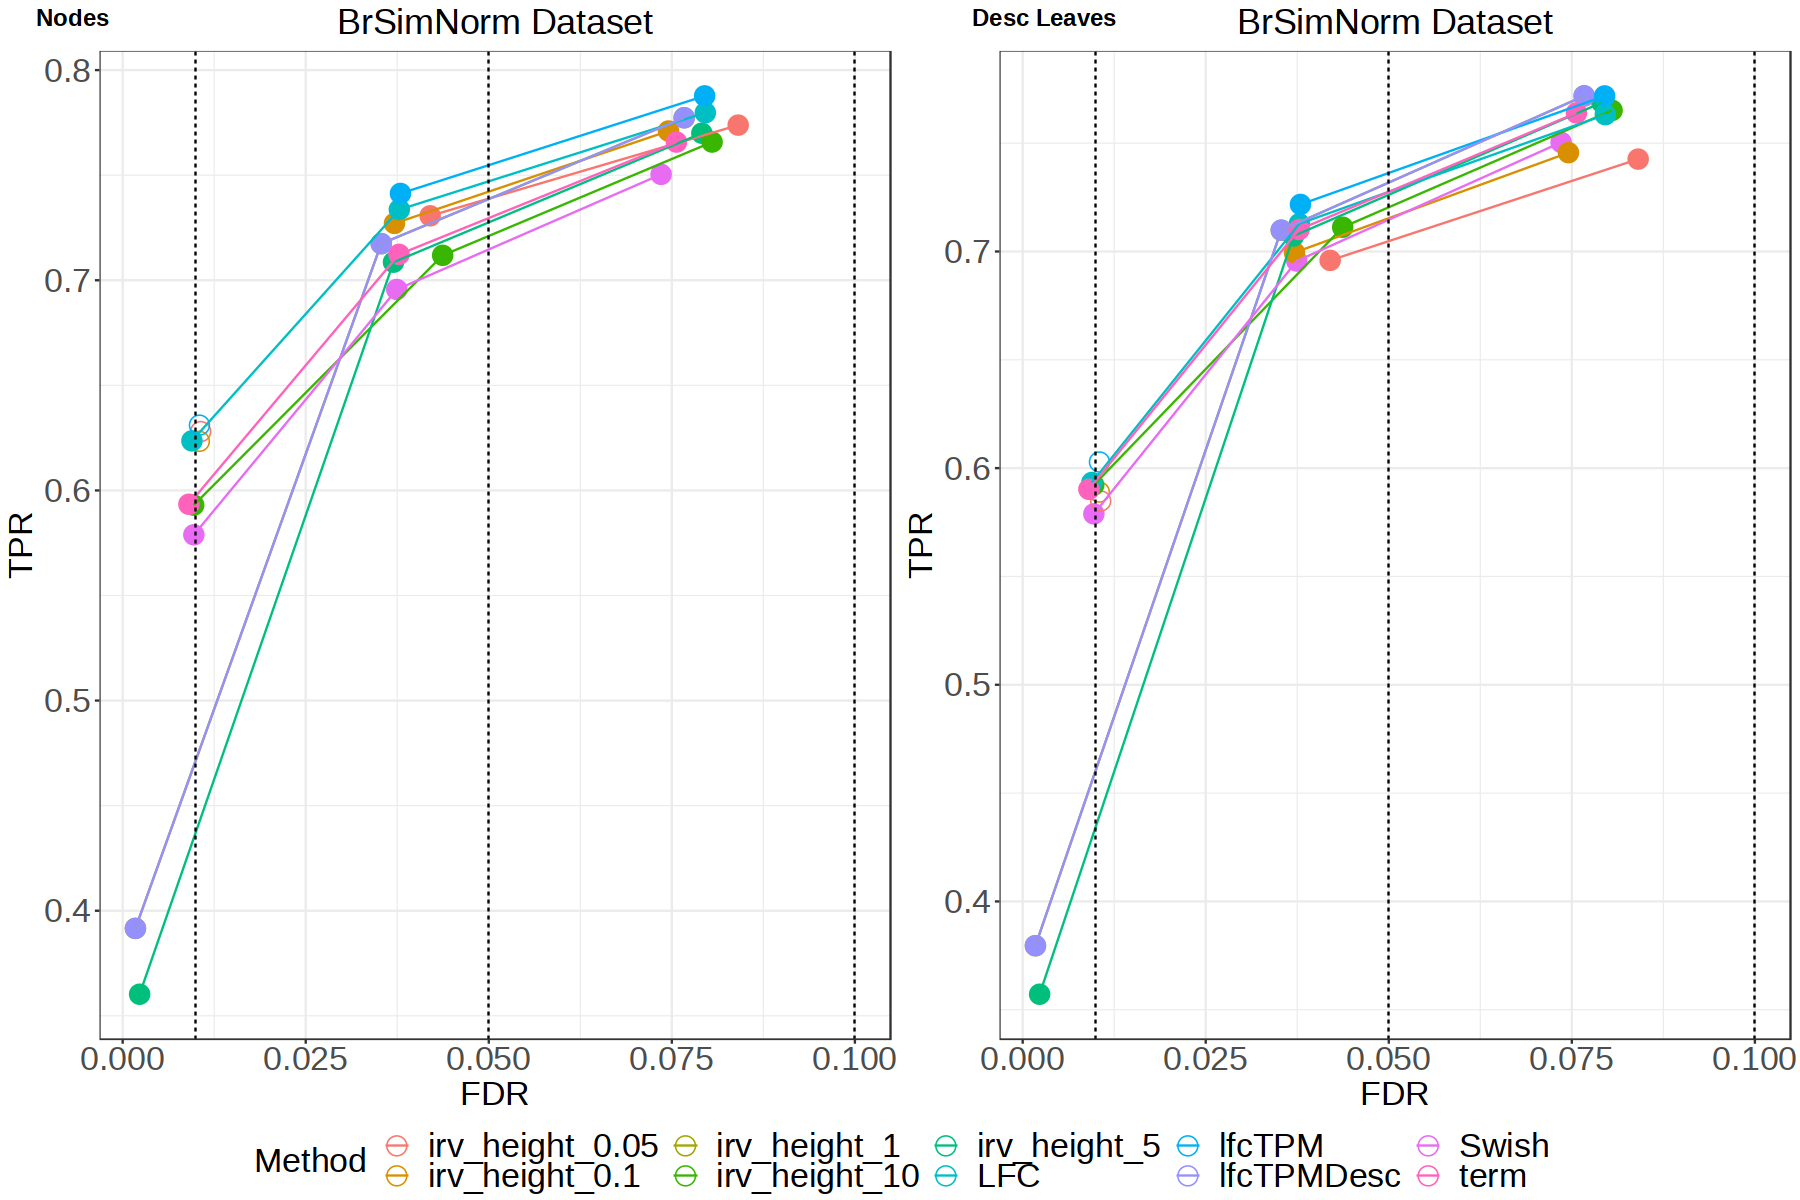

In [10]:
ggarrange(pCons, pConsDesc, common.legend = T, labels = c("Nodes", "Desc Leaves"), legend = "bottom")